In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import sys
sys.path.insert(0, '../../../rb_utils/')
sys.path.insert(0, '../../rb_utils/')
import common_utils 

# Load data

In [3]:
data_dir = './mnist_data/'
propn_sample = 0.01

In [4]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [5]:
batchsize = 5

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [6]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [7]:
slen = data_train['image'].shape[-1]

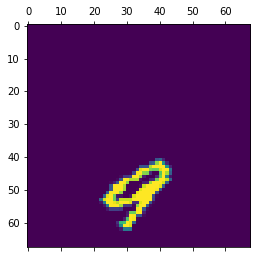

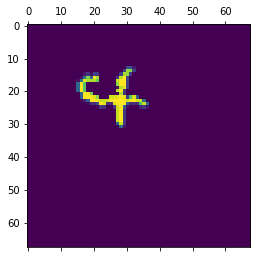

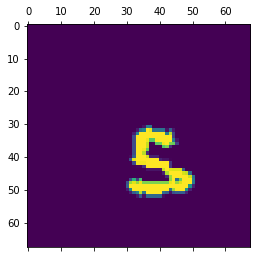

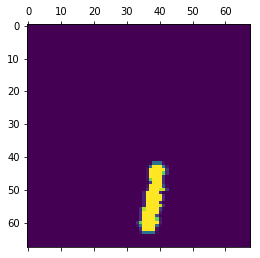

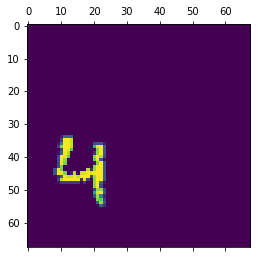

In [8]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

# Define VAE

In [9]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

In [10]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [11]:
full_slen = image.shape[-1]

pixel_1d = pixel_2d[:, 1] * 68 + pixel_2d[:, 0]

one_hot_pixel = common_utils.get_one_hot_encoding_from_int(pixel_1d, full_slen**2)

In [15]:
cropped_image = moving_mnist_vae.crop_image(image, one_hot_pixel)

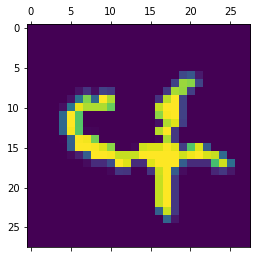

In [17]:
plt.matshow(cropped_image[1, :].view(28, 28))

In [11]:
kernel_size = moving_mnist_vae.mnist_slen

In [75]:
weight = torch.zeros(kernel_size**2, 1, kernel_size, kernel_size)
k = 0
for i in range(kernel_size): 
    for j in range(kernel_size): 
        weight[k, :, i, j] = 1
        k = k + 1

In [76]:
out = f.conv2d(image, weight, padding = int(kernel_size / 2))
out = out[:, :, 0:-1, 0:-1]

In [77]:
out.shape

torch.Size([5, 784, 68, 68])

In [78]:
out = out.contiguous().view(batchsize, kernel_size**2, full_slen**2)

In [79]:
out.shape

torch.Size([5, 784, 4624])

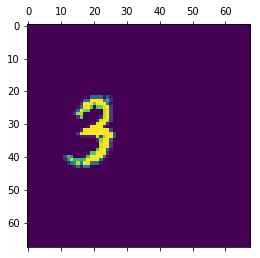

In [80]:
plt.matshow(image[0, 0, :, :])

In [85]:
pixel_2d

tensor([[ 20,  32],
        [ 48,  37],
        [ 19,  15],
        [ 22,  14],
        [ 14,  18]])

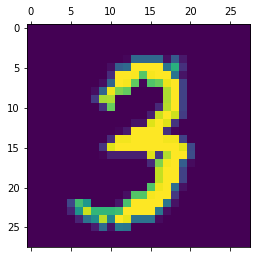

In [88]:
plt.matshow(out[0, :, 32 * 68 + 20].view(kernel_size, kernel_size))

In [11]:
slen_full = 68
padding = 14
pixel_1d = torch.Tensor([0, 0, 0, 0, 0])

In [12]:
pixel_2d = mnist_data_utils.pixel_1d_to_2d(slen_full, padding, pixel_1d)

In [ ]:
# image = image.view(1, 1, self.mnist_slen, self.mnist_slen)
# image_translated = pad_image(image, pixel_2d, grid_out = self.grid_out)

In [14]:
for i in range(5): 
    one_hot_pixel = torch.zeros((5, 41**2))
    one_hot_pixel[:, i] = 1
    out = moving_mnist_vae.crop_image(image, one_hot_pixel)

    plt.matshow(out[0, :].view(28, 28))

RuntimeError: invalid argument 2: size '[5 x 784 x 1681]' is invalid for input with 18663120 elements at /opt/conda/conda-bld/pytorch-cpu_1524582300956/work/aten/src/TH/THStorage.c:41

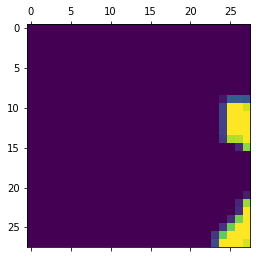

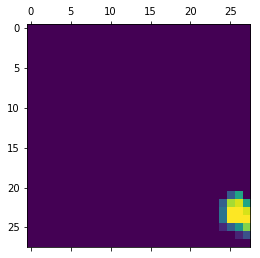

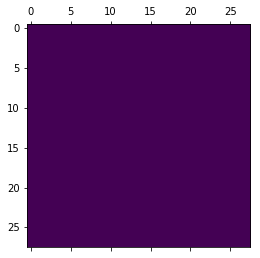

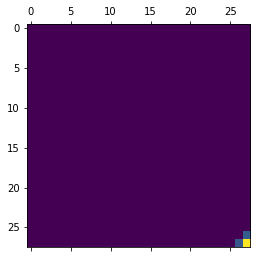

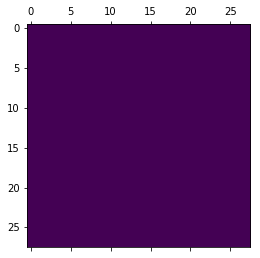

In [45]:
one_hot_pixel = torch.zeros((5, 41**2))
one_hot_pixel[:, 3] = 1
out = moving_mnist_vae.crop_image(image, one_hot_pixel)

for i in range(batchsize): 
    plt.matshow(out[i, :].view(28, 28))

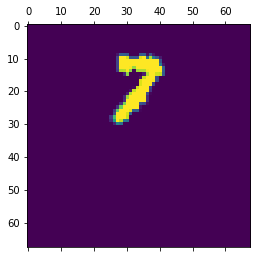

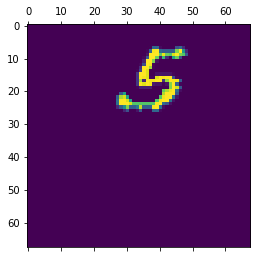

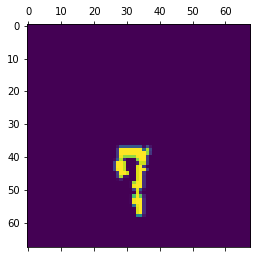

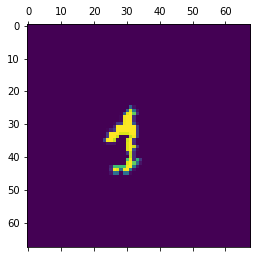

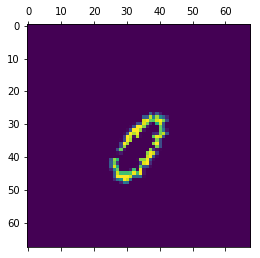

In [27]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [15]:
# moving_mnist_vae.get_rb_loss(image)

In [11]:
# Check padding and cropping functions

In [12]:
mnist_slen = 28
cropped_images = moving_mnist_vae.crop_image(image, pixel_2d)

In [13]:
cropped_images.shape

torch.Size([5, 1, 29, 29])

In [14]:
repadded_images = moving_mnist_vae.pad_image(cropped_images, pixel_2d)

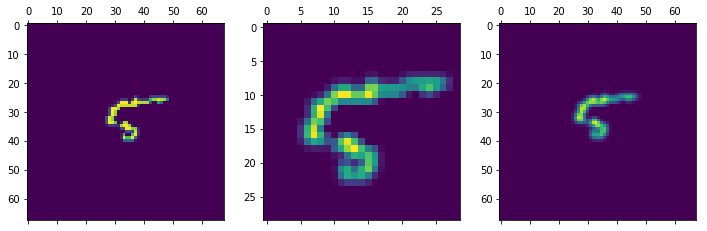

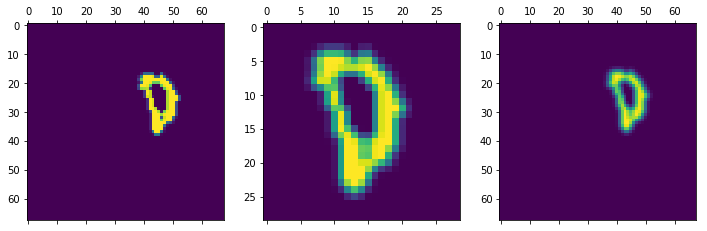

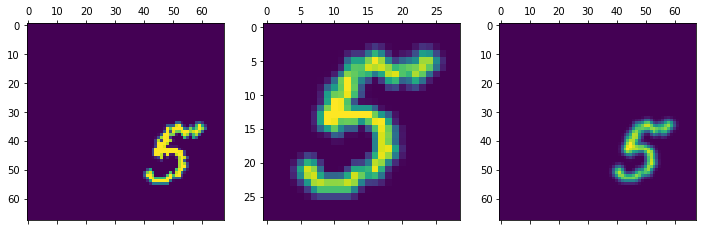

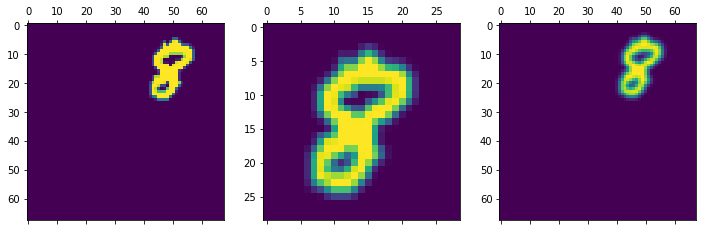

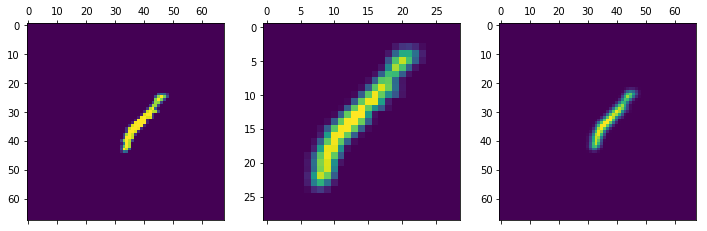

In [15]:
for i in range(batchsize): 
        
    _, axarr = plt.subplots(1, 3, figsize=(12, 12))
    
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(cropped_images[i, 0, :, :])
    axarr[2].matshow(repadded_images[i, 0, :, :])

In [16]:
image.shape

torch.Size([5, 1, 68, 68])

In [17]:
cropped_images.shape

torch.Size([5, 1, 29, 29])

In [18]:
repadded_images.shape

torch.Size([5, 1, 68, 68])

In [19]:
# Checking 1d - 2d conversion 

In [20]:
pixel_1d = moving_mnist_vae._pixel_1d_from_2d(pixel_2d)

In [21]:
pixel_2d_re = mnist_data_utils.pixel_1d_to_2d(moving_mnist_vae.full_slen,
                                    padding = 0,
                                    pixel_1d = pixel_1d)

In [22]:
assert np.all(pixel_2d == pixel_2d_re)

In [23]:
class_weights = moving_mnist_vae._get_class_weights_from_pixel_2d(pixel_2d)

In [24]:
assert np.all(pixel_1d == torch.argmax(class_weights, dim = 1))

In [25]:
class_weights.sum(1, keepdim = True)

tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]])

# Check training goes through

In [26]:
weight_decay = 1e-6
lr = 0.001

optimizer = optim.Adam([
                {'params': moving_mnist_vae.parameters(),
                'lr': lr,
                'weight_decay': weight_decay}])

In [27]:
vae_training_lib.train_vae(moving_mnist_vae, train_loader, test_loader, optimizer,
                outfile = './mnist_vae_results/test',
                n_epoch = 5, print_every = 2, save_every = 2, topk = 5,
                set_true_loc = True)

  * init train recon loss: 577.3759155;
  * init test recon loss: 577.4418945;
[1] unlabeled_loss: 261.9356689  	[2.5 seconds]
[2] unlabeled_loss: 203.1589203  	[2.5 seconds]
  * train recon loss: 192.6136932;
  * test recon loss: 194.3139954;
writing the parameters to ./mnist_vae_results/test_epoch2

[3] unlabeled_loss: 190.8757324  	[2.4 seconds]
[4] unlabeled_loss: 186.6214752  	[2.1 seconds]
  * train recon loss: 184.5228271;
  * test recon loss: 183.3239594;
writing the parameters to ./mnist_vae_results/test_epoch4

[5] unlabeled_loss: 183.8429871  	[3.0 seconds]
writing the parameters to ./mnist_vae_results/test_final



In [28]:
np.load('./mnist_vae_results/test_test_losses.npy')

array([577.4419 , 194.314  , 183.32396], dtype=float32)